# Choosing a threshold

Imagine that you are a data analyst. You are given two sets of CLKs (possibly generated using clkhash) and it is your task to use anonlink produce a linkage.

Luckily for you, anonlink takes care of most of this process. However, it needs to be given one parameter: the _threshold_. The threshold is a number that defines how similar two CLKs must be in order to be accepted as a match. In this example, we are using the Sørensen–Dice coefficient as the similarity metric, so the threshold is a number between 0 and 1.

Choosing a threshold can be nontrivial, but anonlink has some tools to help you with this selection. Let's explore them.

In [1]:
# Preparation
%matplotlib inline

In [2]:
import base64
import json

import bitarray
import matplotlib.pyplot as plt

import anonlink


plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['figure.dpi'] = 100


def to_bitarray(bytes_):
    ba = bitarray.bitarray()
    ba.frombytes(bytes_)
    return ba


def load_clks(path):
    with open(path) as f:
        json_obj = json.load(f)['clks']
    return tuple(map(to_bitarray, map(base64.b64decode, json_obj)))


clks1 = load_clks('clks-1.json')
clks2 = load_clks('clks-2.json')

## Computing similarities
We are going to produce a few plots that will give us hints to the location of the threshold. These plots use the distribution of the similarity scores. This means that before we can make them, we need to compute some similarities.

As a complication, to compute similarity scores, we need to input a threshold. _This_ threshold is not used for linkage—it is merely a cutoff value for our plots. Higher thresholds save processing time, but may produce incomplete graphs. For plotting purposes, a threshold value of 0 is safe, as long as you don't mind waiting a little.

In [3]:
PLOTTING_THRESHOLD = 0

all_candidate_pairs = anonlink.candidate_generation.find_candidate_pairs(
        [clks1, clks2],
        anonlink.similarities.dice_coefficient,
        PLOTTING_THRESHOLD)

## Histogram of similarities
Let's plot a histagram of all the similarity scores! We'll use a log scale to deal with differences in order of magnitude.

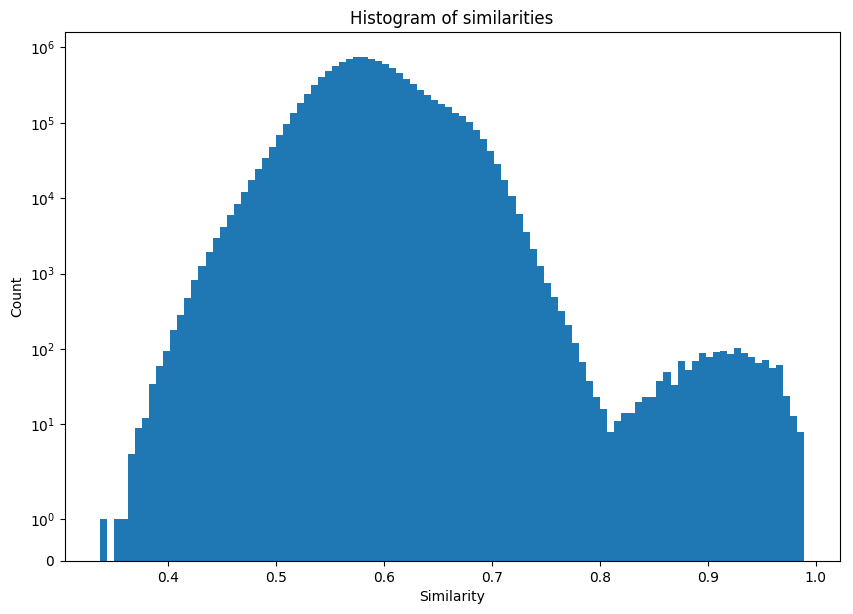

In [4]:
def plot_similarities_hist(candidate_pairs, bins=100):
    """Plot a histogram of the similarity scores in candidate pairs.

    :param candidate_pairs: The candidate pairs.
    :param bins: An integer determining the number of bins to use.
        Default 100.
    """
    counts, bin_boundaries = anonlink.stats.similarities_hist(candidate_pairs, bins)
    plt.hist(bin_boundaries[:-1], bins=bin_boundaries, weights=counts)
    plt.yscale('symlog')  # Log scale, but lets some values be 0
    plt.title('Histogram of similarities')
    plt.xlabel('Similarity')
    plt.ylabel('Count')


plot_similarities_hist(all_candidate_pairs)

We can clearly see two populations. A big population of non-matching pairs with similarities <0.8 and a much smaller population of matching pairs with similarities >0.8.

The large separation between those population is a sign that our data is reasonably clean and our encoding schema is doing a good job. The populations are not separated as cleanly in more difficult problems.

Generally, the optimal threshold will be at the bottom of the trough between the two distributions.

## Cumulative matches by threshold
We can also plot the number of matches we would get by setting a particular threshold.

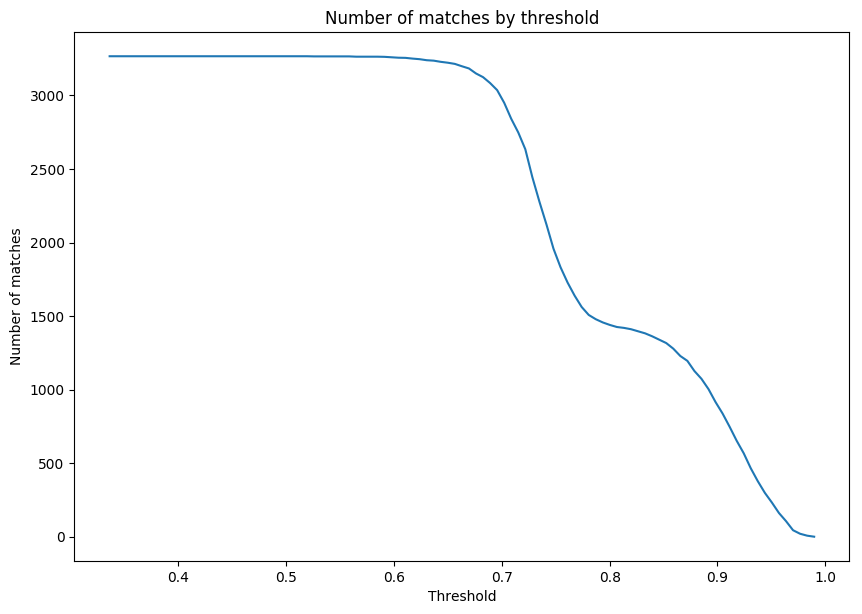

In [5]:
def plot_cumul_number_matches_vs_threshold(candidate_pairs, steps=100):
    """Plot the number of matches for each threshold.

    We use the 2-party greedy solver to calculate the number of matches
    that would be returned if the candidate_pairs were found using a
    particular threshold. This function requires only a single pass of
    the data, so it is faster than simply running the greedy solver
    multiple times.

    :param candidate_pairs: The candidate pairs.
    :param steps: An integer determining the number of threshold steps
        to use. Default 100.
    """
    num_matches, thresholds = anonlink.stats.cumul_number_matches_vs_threshold(
        candidate_pairs, steps)
    plt.plot(thresholds, num_matches)
    plt.title('Number of matches by threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Number of matches')

    
plot_cumul_number_matches_vs_threshold(all_candidate_pairs)

We can see that the curve levels off around threshold of 0.8.

The set of all possible pairs can be split into (1) a set of matches that may or may not be accepted (depending on the threshold) and (2) a much bigger set of pairs that will never be accepted by the greedy solver. The smaller set of possible matches has two well-separated subpopulations, and 0.8 appears to be right in-between. This makes 0.8 a good threshold.

In less clean data, there might not be a clearly visible 'saddle point'.

## Possible matches vs definite nonmatches ratio by threshold
Finally, we can split the similarities into many buckets by threshold, and plot the ratio of possible matches against definite nonmatches by threshold. Definite nonmatches are pairs that will never be accepted by the greedy solver, whereas possible matches are ones that may or may not be accepted, depending on the threshold.

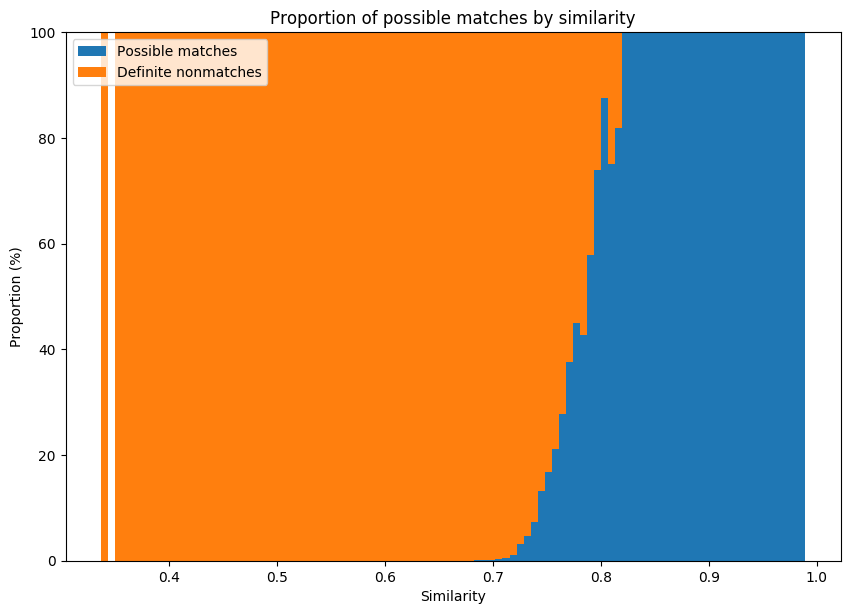

In [6]:
def plot_matches_nonmatches_ratio_hist(candidate_pairs, bins=100):
    """Plot the ratio of possible matches and definite nonmatches.

    We use the greedy solver to split the candidate pairs into possible
    matches and definite nonmatches. A possible match may or may not be
    accepted as a pair depending on the threshold chosen. A definite
    nonmatch will never be accepted, since one record in this pair has
    a more promising match with another record. We then plot the ratio
    of possible matches and definite nonmatches.

    :param candidate_pairs: The candidate pairs.
    :param bins: An integer determining the number of bins to use.
        Default 100.
    """
    matches_num, nonmatches_num, bin_boundaries = anonlink.stats.matches_nonmatches_hist(
        candidate_pairs, bins)
    all_num = matches_num + nonmatches_num

    nonmatches_ratio = [nn * 100 / an if an else 0 for nn, an in zip(nonmatches_num, all_num)]
    matches_ratio = [mn * 100 / an if an else 0 for mn, an in zip(matches_num, all_num)]
    width = (bin_boundaries[-1] - bin_boundaries[0]) / (bin_boundaries.shape[0] - 1)

    plt.bar(bin_boundaries[:-1], matches_ratio,
            width=width, align='edge', label='Possible matches')
    plt.bar(bin_boundaries[:-1], nonmatches_ratio,
            width=width, bottom=matches_ratio, align='edge', label='Definite nonmatches')
    plt.legend()
    plt.title('Proportion of possible matches by similarity')
    plt.xlabel('Similarity')
    plt.ylabel('Proportion (%)')

    
plot_matches_nonmatches_ratio_hist(all_candidate_pairs)

We find that all matches with a threshold of around 0.8 or more are accepted. This reinforces our previous beliefs that a good threshold is around 0.8.

## Deciding on a threshold
The above plots let us decide on a threshold. It will be around 0.8. Let's pick 0.81, since that's where the trough in the first plot lies.

## Results
Using the plots above, an analyst might choose a threshold of 0.81. Let's perform this linkage.

In [7]:
THRESHOLD = .81

results_candidate_pairs = anonlink.candidate_generation.find_candidate_pairs(
        [clks1, clks2],
        anonlink.similarities.dice_coefficient,
        THRESHOLD)
solution = anonlink.solving.greedy_solve(results_candidate_pairs)

found_pairs = {(i, j) for (_, i), (_, j) in map(sorted, solution)}

We can cheat a little since we actually have the ground truth. (Normally having the ground truth would defeat the point of this linkage!) Let's compute the actual accuracy.

In [8]:
with open('ground-truth.json') as f:
    true_pairs = set(map(tuple, json.load(f)))
    
true_positives = len(found_pairs & true_pairs)
false_positives = len(found_pairs) - true_positives
false_negatives = len(true_pairs) - true_positives

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * true_positives / (2 * true_positives + false_negatives + false_positives)

print(f'Precision: {precision:0.3}')
print(f'Recall: {recall:0.3}')
print(f'F1 score: {f1_score:0.3}')

Precision: 0.996
Recall: 0.981
F1 score: 0.989


An F1 score of .99 is very good. We might be able to improve upon it by adding another significant figure to our threshold (of course, finding it would require more fine-grained plots).

Small deviations on this threshold would help us fine-tune the balance between precision and recall.